In [1]:
# https://github.com/mendableai/QA_clustering/blob/main/notebooks/clustering_approach.ipynb

In [2]:
import os
import ast
import pandas as pd 
import numpy as np
from langchain import LLMChain
from langchain_community.chat_models import ChatOllama
from langchain.prompts import PromptTemplate
from langchain.chains.mapreduce import MapReduceChain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import (
                StuffDocumentsChain,
                LLMChain,
                ReduceDocumentsChain,
                MapReduceDocumentsChain,
            )
from langchain_huggingface import HuggingFaceEmbeddings
import nest_asyncio
import phoenix as px
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace.langchain import LangChainInstrumentor


nest_asyncio.apply()

In [3]:
session = px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [40]:
llm = ChatOllama(model='phi3', temperature=0.0)

In [5]:
embedding_model = HuggingFaceEmbeddings(
    model_name='mixedbread-ai/mxbai-embed-large-v1',
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': False}
)

In [6]:
LangChainInstrumentor().instrument()

In [8]:
# def get_embedding(text):
#     try:
#         result = embedding_model.embed_query(text)
#     except:
#         print("tex: ", text)
#         result = np.zeros(512)
#     return result

# df['embedding'] = df['message'].apply(get_embedding)

In [13]:
# Read data
df = pd.read_csv("data/quora_questions_embed.csv")
df['embedding'] = df['embedding'].apply(lambda x: ast.literal_eval(x))
df.head()

,message,embedding
0,How does Quora look to a moderator?,"[0.21555110812187195, -0.838441789150238, -0.9..."
1,How do I refuse to chose between different thi...,"[-1.1308321952819824, -0.029309488832950592, -..."
2,Did Ben Affleck shine more than Christian Bale...,"[1.3621402978897095, -0.68434739112854, 0.6016..."
3,What are the effects of demonitization of 500 ...,"[-0.41592833399772644, 0.6450150012969971, -0...."
4,Why creativity is important?,"[0.18101975321769714, 0.5497534275054932, -0.2..."


In [14]:
#turn the df["embedding"] column into an np matrix
embeddingMatrix = np.array(df["embedding"].tolist())
#print the shape of the matrix
print(embeddingMatrix.shape)
print(type(df['embedding'].iloc[0]))

(15000, 1024)
<class 'list'>


In [15]:
# Clustering with KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Optimal number of clusters: 29


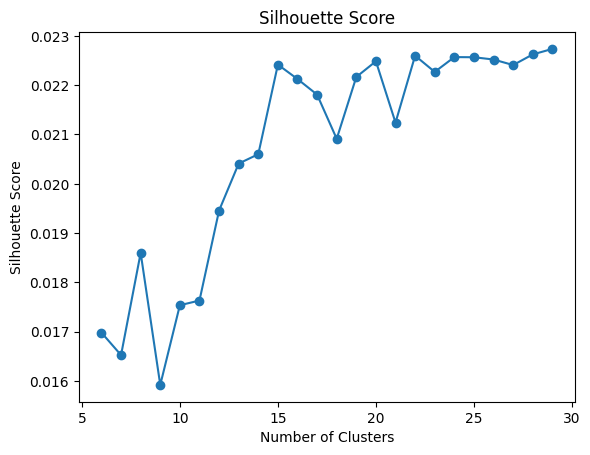

In [19]:
# Find number of clusters
silhouette_scores = []
cluster_range = range(6, 30)  # Silhouette Score is not defined for 1 cluster

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(embeddingMatrix)
    labels = kmeans.labels_
    score = silhouette_score(embeddingMatrix, labels)
    silhouette_scores.append(score)

best_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters:", best_n_clusters)

plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")
plt.show()

In [20]:
n_clusters = 15 # lets choose 15

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(embeddingMatrix)
labels = kmeans.labels_

df["Cluster"] = labels

df.groupby("Cluster")

0 yellowgreen
1 firebrick
2 aqua
3 mediumturquoise
4 mediumaquamarine
5 lawngreen
6 thistle
7 mediumaquamarine
8 lavender
9 lightslategray
10 yellow
11 mediumblue
12 thistle
13 limegreen
14 olivedrab


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

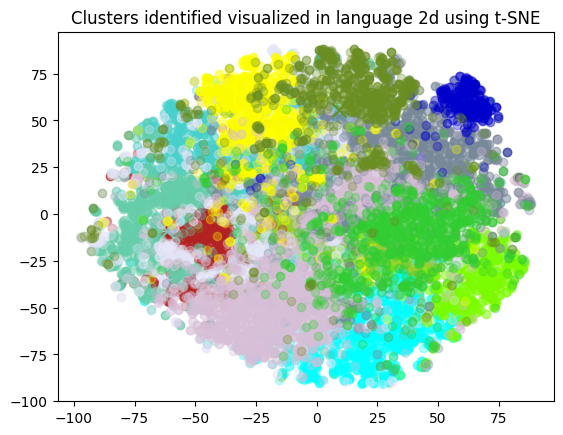

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(embeddingMatrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

colors = np.random.choice(list(mcolors.CSS4_COLORS.keys()), 15)
for category, color in enumerate(colors[:n_clusters]):
    print(category, color)
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [25]:
size_and_cluster_number.sort_index()

,0
Cluster,
0,1086
1,753
2,1147
3,1084
4,864
5,826
6,800
7,315
8,888


In [32]:
# sort clusters by their size, and create a new dataframe with the size and cluster number in sorted order. Maintain other columns
size_and_cluster_number = pd.DataFrame(df.groupby("Cluster").size().sort_values(ascending=False))

# print out 10 messages from n cluster
for cluster_number, size in size_and_cluster_number.sort_index().iterrows():

    print(f"{cluster_number} has {size[0]} messages")
    try: 
        print(df[df.Cluster == cluster_number].sample(5).message.values)
        print("\n")

    except:
        print(df[df.Cluster == cluster_number].sample(1).message.values)
        print("\n")

0 has 1086 messages
['How do I become a guest speaker on NPR?' 'How do I teach myself?'
 'How do I deal with people who think they are smarter than me?'
 'What is the best way to quit excessive internet addiction?'
 'What is the easiest way to learn punctuation?']


1 has 753 messages
['How do I proceed in the web application development?'
 'How much time would it take to learn a new language?'
 'What at the advantages of PC games over console games?' 'What is UNIX?'
 'What is the difference between UX and UI designer and web designer?']


2 has 1147 messages
['How can I get abs in a week?'
 'What are the causes of long term memory loss?'
 'Are mobiles harmful for health?'
 'How do you check if you have any type of cancer?'
 'What clothes should I wear to the gym?']


3 has 1084 messages
['Is there any tool to generate FIFA 17 coins quickly?'
 'How do I open a demat account?' "What's the best way to sell art?"
 'What is the benefits of payroll outsourcing services?'
 'How does a change

In [33]:
# Sample questions

In [47]:
from langchain.text_splitter import CharacterTextSplitter

def create_doc(messages, max_tokens=2000):
    #sample around 400 messages from the cluster
    input_doc = '\n\n'.join(messages)

    text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens,chunk_overlap=0,separator="\n\n")
    # Sanity check
    split_texts = text_splitter.split_text(input_doc)
    
    # text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=16000,chunk_overlap=0,separator="\n\n")
    return split_texts[0]


# for clusters, create docs and save in list
docs = []
for cluster_number, size in size_and_cluster_number.iterrows():
    print(f"{cluster_number} has {size} messages")
    messages = df[df.Cluster == cluster_number].message.values
    doc = create_doc(messages)
    print(doc)
    print("\n\n")
    docs.append(doc)

12 has 0    1828
Name: 12, dtype: int64 messages
Can we map the surface (and the subsurface) of a planet using cosmic rays or very high frequency gamma rays with ground based telescopes?

Who created the "GOD"?

What causes nuclear reactions in the Sun?

Is the lowest sum rule still used in naming organic compounds?

What are the requirements of modulation?

What is a conjecture? What are some examples?

Can anime exist in a parallel universe/multiverse?

Why does phase shift take place in the output of the common emitter amplifier when compared to the input signal?

What's the fastest tank ever to be made?

What is the greatest mystery in earth?

What are the 12 organ systems? Why are they important?

Which is the largest black hole found to date?

What is "sampling" in research methodology?

What is the speed of electricity and why?

Who would win in a fight: Goku or the Hulk?

Whey is the sky blue?

If dark/vacuum energy is created with expansion and it has no limit, could infinite 

In [36]:
# Summarize with LLM

In [69]:
from langchain import PromptTemplate


map_template_string = """The following is a list of questions, commands, and keyords that have been entered into a Q+A system
{questions}

Based on this list of questions, please do 3 things:
(1) Identify the main theme
(2) Give a list of main sub-themes
(3) Give a representitive example question in each sub-theme
(4) estimate the proportion of questions that fall into each theme
(5) Dont use information from any previous questions and conversation, but rather only the information provided above.
(6) Restrict the response to 500 words.


Helpful Answer:"""


MAP_PROMPT = PromptTemplate(input_variables=["questions"], template=map_template_string)

In [70]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=16000,chunk_overlap=0,separator="\n\n")

def run_map(input_doc):


    llm = ChatOllama(model='phi3', temperature=0.0, cache=False, keep_alive=1, num_ctx=4000)

    map_llm_chain = LLMChain(llm=llm, prompt=MAP_PROMPT)

    
    return map_llm_chain.run(questions=input_doc)

In [71]:
# print(docs[0])

In [72]:
test_result = run_map(docs[0])

print(test_result)

 Main Theme: Exploration of Scientific Concepts and Phenomena in Various Fields

Sub-themes:
1. Physics (Cosmic Rays, Amplifiers, Black Holes)
2. Biology & Evolutionary Science (DNA Replication, Organisms' Size Differences)
3. Astronomy & Cosmology (Planet Surfaces, Multiverse Theories)
4. Environmental Science (Climate Change, Renewable Resources)
5. Engineering and Technology (Robotics, Electronic Devices)
6. Chemistry & Materials Science (Synthetic Gold, Batteries)
7. Earth Sciences (Volcanoes, Water Cycle)
8. Mathematical Concepts in Biology (Punnett Squares, Genetics)
9. Philosophy of Science and Existence 
10. Miscellaneous Scientific Inquiries & Technological Aspects

Representitive Example Questions:
Physics - How does phase shift occur in the output signal compared to input? (25%)
Biology & Evolutionary Science - Why is it that male mammals are generally bigger than females, and what evolutionary advantage might this confer? (15%)
Astronomy & Cosmology - Can anime exist within

In [74]:
initial_results = []

for input_doc in docs:
    result=run_map(input_doc)
    initial_results.append(result)

In [75]:
#print results
for i, result in enumerate(initial_results):

    #print size of cluster
    print(f"Cluster {i} has {size_and_cluster_number.iloc[i].values[0]} messages: \n")

    #print the summary
    print(result)

    #print separator
    print("\n===============================================================\n\n")
    

Cluster 0 has 1828 messages: 

 Main Theme: Exploration of Scientific Concepts and Phenomena in Various Fields

Sub-themes:
1. Physics (Cosmic Rays, Amplifiers, Black Holes)
2. Biology & Evolutionary Science (DNA Replication, Organisms' Size Differences)
3. Astronomy & Cosmology (Planet Surfaces, Multiverse Theories)
4. Environmental Science (Climate Change, Renewable Resources)
5. Engineering and Technology (Robotics, Electronic Devices)
6. Chemistry & Materials Science (Synthetic Gold, Batteries)
7. Earth Sciences (Volcanoes, Water Cycle)
8. Mathematical Concepts in Biology (Punnett Squares, Genetics)
9. Philosophy of Science and Existence 
10. Miscellaneous Scientific Inquiries & Technological Aspects

Representitive Example Questions:
Physics - How does phase shift occur in the output signal compared to input? (25%)
Biology & Evolutionary Science - Why is it that male mammals are generally bigger than females, and what evolutionary advantage might this confer? (15%)
Astronomy & Cos